In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 8
# rcParams['figure.dpi'] = 300


from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [40]:
import numba
from numba import jit

In [41]:
import sklearn
Y = sklearn.datasets.make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)[0]
Y = Y[np.argsort(Y[:,0]),]
Y += np.random.normal(0,0.05, Y.shape)

In [42]:
p = Y.shape[0]
n = Y.shape[1]

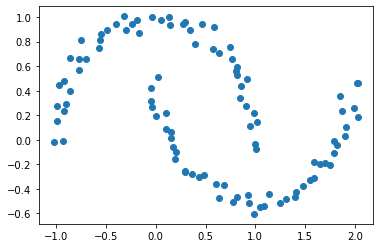

In [43]:
plt.scatter(Y[:,0],Y[:,1])

In [44]:
D = np.zeros([p,p])

In [45]:
D

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
for i in range(p):
    for j in range(i):
        D[i,j] = np.sqrt(np.sum((Y[i]-Y[j])**2))
        D[j,i] = D[i,j]

In [47]:
@jit(nopython=True)
def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return int(k/ncol), k%ncol

In [48]:
# @jit(nopython=True)
def FindMST(A):
    

    p = A.shape[0]
    MST = np.zeros((p,p))

    Xl = list()
    Vl = list(range(p))
    Xl.append(0)
    Vl.remove(0)

    i = 0
    while len(Vl)>0:
        idx0, idx1 = find_min_idx(A[Xl][:,Vl])

        MST[Xl[idx0],Vl[idx1]]=1

        Xl.append(Vl[idx1])
        Vl.remove(Vl[idx1])

        i+=1
    
    return MST + MST.T

In [49]:
find_min_idx(D[1:])

(0, 1)

In [50]:
MST = FindMST(D)
mst0 = MST.copy()

In [51]:
def getB(A):
    p = A.shape[0]

    B = np.zeros([p,p-1])

    idx = 0
    for i in range(p):
        for j in range(i):
            if A[i,j]==1:
                B[i,idx]=1
                B[j,idx]=-1
                idx+=1
    return B

In [52]:
@jit(nopython=True)


def getA(B):
    A = - B@B.T
    np.fill_diagonal(A,0)
    return A

In [53]:
A = MST
B = getB(A)

In [54]:
B2Inv = np.linalg.inv(B.T@B)

In [55]:
B2Inv

array([[ 0.99, -0.98, -0.97, ..., -0.01, -0.02, -0.01],
       [-0.98,  1.96,  1.94, ...,  0.02,  0.04,  0.02],
       [-0.97,  1.94,  2.91, ...,  0.03,  0.06,  0.03],
       ...,
       [-0.01,  0.02,  0.03, ...,  0.99, -0.02, -0.01],
       [-0.02,  0.04,  0.06, ..., -0.02,  1.96,  0.98],
       [-0.01,  0.02,  0.03, ..., -0.01,  0.98,  0.99]])

In [56]:

full_edge_idx = np.arange(p-1)
full_node_idx = np.arange(p)

k = 1

sel = full_edge_idx==k
sel_not = full_edge_idx!=k

In [57]:
# def getSubInverse2(B2Inv, k):
    
#     full_edge_idx = np.arange(p-1)
#     full_node_idx = np.arange(p)
    
#     sel = full_edge_idx==k
#     sel_not = full_edge_idx!=k
    
#     B1 = B[:,sel_not]


#     return np.linalg.inv(B1.T@B1)
    

In [58]:
full_edge_idx = np.arange(p-1)
full_node_idx = np.arange(p)

In [59]:
@jit(nopython=True)
def getSubInverse(B2Inv, k):
        
    sel = full_edge_idx==k
    sel_not = full_edge_idx!=k
    
    M11 = B2Inv[sel_not,][:,sel_not]
    M12 = B2Inv[sel_not,][:,sel]
    M22 = B2Inv[sel,][:,sel]

    return M11 - M12@M12.T/M22[0,0]    

In [60]:
# np.sum((getSubInverse(B2Inv,10) - getSubInverse2(B2Inv,10)  )**2)

In [61]:
B2Inv = np.linalg.inv(B.T@B)

In [62]:
B_s_star = np.random.normal(0,1,[p,1])

In [63]:
s0 = 0.1
s1 = 0.5

In [64]:
sigma = np.ones(p) * s0

slab_indicator = np.random.uniform(0,1,p)<0.1

sigma[slab_indicator]= s1

w = 0.01

In [65]:
@jit(nopython=True)
def updateSlab(A,s0,s1, w):

    D2A= D**2*A
    
    slab_indicator = np.zeros(p)
    sigma = np.zeros(p)

    for i in range(p):
        choice0 = -np.sum(D2A[i]/2/s0) - np.sum(A[i])*np.log(s0) + np.log(1-w)
        choice1 = -np.sum(D2A[i]/2/s1) - np.sum(A[i])*np.log(s1) + np.log(w)
        slab_indicator[i] = np.argmax(np.array([choice0,choice1])+np.random.gumbel(0,1,2))==1
        if(slab_indicator[i]):
            sigma[i]=s1
        else:
            sigma[i]=s0

    return slab_indicator, sigma

In [66]:
@jit(nopython=True)
def compLogP(D, sigma):
    logP =-(D**2/sigma).T/sigma
    logP = (logP - np.log(sigma)).T- np.log(sigma)
    return logP

In [67]:
@jit(nopython=True)

def findRowColIdx(idx,m1,m2):
    r = int(idx / m2)
    return (r,     idx - r*m2)

In [68]:
@jit(nopython=True)

def NulSpaceB(B,k):
    
    full_edge_idx = np.arange(p-1)
    full_node_idx = np.arange(p)
    
    sel = full_edge_idx==k
    sel_not = full_edge_idx!=k
    B_not_k = B[:,sel_not]
    B_k = B[:, sel]

    beta_k = (np.eye(p) - B_not_k@np.linalg.inv(B_not_k.T@B_not_k)@B_not_k.T)@B_k
    
    return beta_k

In [69]:
# @jit(nopython=True)

def updateB(B, logP):

    full_edge_idx = np.arange(p-1)
    full_node_idx = np.arange(p)

    for k in range(p-1):

#         sel = full_edge_idx==k
#         sel_not = full_edge_idx!=k
#         B_not_k = B[:,sel_not]
#         B_k = B[:, sel]

#         beta_k = (np.eye(p) - B_not_k@np.linalg.inv(B_not_k.T@B_not_k)@B_not_k.T)@B_k
#         beta_k = np.round(beta_k.flatten(),10)
# #         beta_k = (beta_k.flatten()*1E8).astype('int')

        beta_k = NulSpaceB(B,k)
        beta_k = np.round(beta_k.flatten(),10)

        unique_values = np.unique(beta_k) #list(set(beta_k))

        if len(unique_values)!=2:
            print("error")

        subgraph0 = beta_k==unique_values[0]
        subgraph1 = beta_k==unique_values[1]

        subgraph0_node_idx = full_node_idx[subgraph0]
        subgraph1_node_idx = full_node_idx[subgraph1]

        logp_choices =  logP[subgraph0_node_idx,:][:,subgraph1_node_idx]

        m1,m2 = logp_choices.shape
        logp_gumbel = logp_choices + np.random.gumbel(0,1, logp_choices.shape)
        idx = np.argmax(logp_gumbel)

        r_idx, c_idx = findRowColIdx(idx,m1,m2)


        new_idx0= subgraph0_node_idx[r_idx]
        new_idx1= subgraph1_node_idx[c_idx]

        B[:,k] = 0
        B[new_idx0,k]=1
        B[new_idx1,k]= - 1

    return B

In [70]:
import copy

In [71]:
A_trace = list()

In [73]:
import time
start = time.time()




for k in range(1000):
    
    logP =  compLogP(D,sigma)
    
    slab_indicator, sigma = updateSlab(A,s0,s1,w)
    
    B = updateB(B,logP)
    A = getA(B)

    A_trace.append(A.copy())
    
    if (k+1) % 100==0:
        print(k)
    
#     print(np.abs(A-mst0).sum())


end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

99
199
299
399
499
599
699
799
899
999
Elapsed (with compilation) = 46.33880281448364


In [74]:
print(np.abs(A-mst0).sum())

160.0


In [75]:
mst_trace_arr = np.array(A_trace)

In [76]:
mean_mst = mst_trace_arr.mean(0)

In [ ]:
# plt.plot(mst_trace_arr[:100,96,97])

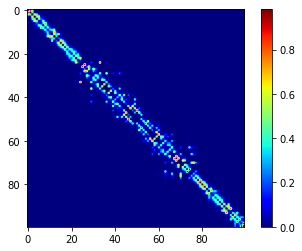

In [77]:
plt.imshow(mean_mst, vmin=0,cmap='jet')
plt.colorbar()

In [ ]:
import igraph

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

In [ ]:
c_vec = ['lightblue']*50
# c_vec[3] = 'red'
# c_vec[2] = 'yellow'
# c_vec[4] = 'purple'


In [ ]:
a= mst_trace_arr[200]
np.fill_diagonal(a,0)
a= a.round()

g = igraph.Graph.Adjacency((a > 0).tolist())
g.to_undirected()

layout = zip(list(-Y[:,0]), list(Y[:,1])) 
out =  igraph.plot(g, layout = layout, vertex_color = c_vec)

# out.save('2moon_tree1.png')


In [ ]:
# a= mst0
# np.fill_diagonal(a,0)
# a= a.round()

# g = igraph.Graph.Adjacency((a > 0).tolist())
# g.to_undirected()

# layout = zip(list(Y[:,0]), list(Y[:,1])) 
# igraph.plot(g, layout = layout)

In [ ]:
D= (np.sum(A,0))

In [ ]:
B.shape

In [ ]:
p

In [ ]:
s = np.arange(p)+1.

In [ ]:
(np.abs(B.T)@ (np.log(s))) 

In [ ]:
B1 = B.copy()

In [ ]:
full_edge_idx = np.arange(p-1)
full_node_idx = np.arange(p)
k=2    
beta_k = NulSpaceB(B,k)
beta_k = np.round(beta_k.flatten(),10)

unique_values = np.unique(beta_k) #list(set(beta_k))

# if len(unique_values)!=2:
# print("error")

subgraph0 = beta_k==unique_values[0]
subgraph1 = beta_k==unique_values[1]

subgraph0_node_idx = full_node_idx[subgraph0]
subgraph1_node_idx = full_node_idx[subgraph1]

logp_choices =  logP[subgraph0_node_idx,:][:,subgraph1_node_idx]

m1,m2 = logp_choices.shape
logp_gumbel = logp_choices + np.random.gumbel(0,1, logp_choices.shape)
idx = np.argmax(logp_gumbel)

r_idx, c_idx = findRowColIdx(idx,m1,m2)


new_idx0= subgraph0_node_idx[r_idx]
new_idx1= subgraph1_node_idx[c_idx]

B[:,k] = 0
B[new_idx0,k]=1
B[new_idx1,k]= - 1

In [ ]:
full_inv = np.linalg.inv(B.T@B)

In [ ]:
full_edge_idx = np.arange(p-1)
full_node_idx = np.arange(p)

sel = full_edge_idx==k
sel_not = full_edge_idx!=k
B_not_k = B[:,sel_not]
B_k = B[:, sel]


In [ ]:
a_star =full_inv[sel_not,:][:,sel_not]
b_star =full_inv[sel_not,][:,sel]
d_star =full_inv[sel,sel]

In [ ]:
a_partial_inv = a_star - b_star/d_star @b_star.T

In [ ]:
# np.linalg.inv(B_not_k.T@B_not_k) - a_partial_inv

In [ ]:
d = B-B1
delta = (B1.T@d + d.T@B1 + d.T@d)

In [ ]:
M_inv_exact = np.linalg.inv(B.T@B)

In [ ]:
M_inv = np.linalg.inv(B1.T@B1)

In [ ]:
approx_res = M_inv - M_inv@delta@M_inv

In [ ]:
np.linalg.eig(M_inv@delta)

In [ ]:
d[:,2]

In [ ]:
(M_inv_exact - M_inv)[3]

In [ ]:
M_inv_exact

In [ ]:
M_inv